## Embeddings extraction
On this notebook I will compare a target image to a pool of other images, this simulates the process where a customer uploads his picture that will be compared to a store catalogue images.  

The strategy will be to use a neural network already trained on the imagenet dataset and use it to extract the embeddings of all the store images. These embeddings will be saved and when a new image is uploaded to the server the embedding of that image will be extracted and compared to the other ones where the "n" most similar images will be returned. To compare the images cosine similarity will be used.

For efficiency purposes embeddings are run only once and exported to a csv file, then the file is loaded into memory.

## To do
- TSNE
- Validation / Test
- Hyperparameters: NNs & distances -plot-
- Fix issues below
    - Duplicate images:
    Some photos may appear in both customer and retrieval folders with different photo id. List below:  
    10104, 10222 - customer belt  
    77679, 77678 - retrieval belt
    - Blank images  
    To be removed (see last on ranked images) 336452
    - Customer images in retrieval
- Simplify all functions

In [1]:
import os
import sys
import re
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from PIL import Image
import cv2
from scipy.spatial.distance import cdist
from extract_train_val_test import extract_train_val_test
%matplotlib inline
pd.options.mode.chained_assignment = None  #disables .loc assignment warning
#from keras.applications.vgg16 import VGG16, preprocess_input
#from keras.applications.mobilenet import MobileNet, preprocess_input
#pip install h5py==2.8.0rc1 to disable the h5py warning

Using TensorFlow backend.


## Selecting the products from the store

For simplicity we will select dresses and tops.  

We are applying a KNeighbors Search algorithm to retrieve similar images, in order to obtain a fair evaluation of the algorithm we will use a similar amount of products and categories that the amount a usual store would have in stock. Given this amount of products per category we want to establish a a series of benchmarks to evaluate the performance of the algorithm **EXPLAIN A BIT MORE ABOUT THE DATASET PAIR MATCHES ETC**  

This means sampling down the amount of products (unique id & unique photo).

### For simplicity filtering out images that have duplicated categories & duplicated bboxes
Duplicated categories are usually troublesome since it means the same photo has been reused for different products and therefore the quality of each of the product is deemed to be poorer than the usual image a customer would upload. A customer is expected to upload a photo with reasonable quality in terms of lighting, perspective and size.

Some of the photos have duplicated bounding boxes, this is due to the same items appearing more than once in the photo or due to other unknown reasons, to make it simple we will filter these photos out too.

In [29]:
customer_df = pd.read_csv("./customer_df.csv")
retrieval_df = pd.read_csv("./retrieval_df.csv")

In [33]:
#filtering by unique photos
freq_categories = pd.DataFrame(customer_df["photo"].value_counts())
freq_categories = freq_categories[freq_categories["photo"] == 1]
customer_df = customer_df[customer_df["photo"].isin(freq_categories.index)]

print(customer_df.shape)
print(customer_df["category"].value_counts())

(9034, 8)
dresses      5996
tops         1164
footwear      568
outerwear     498
leggings      240
skirts        211
bags          132
eyewear       126
pants          46
belts          43
hats           10
Name: category, dtype: int64


### Joining customer and retrieval & filtering categories
This will discard all images that do not match to customer_df. These are images introduced by the original dataset as extra noise.

Will filter categories to dresses and tops. These categories are selected due to the volume of available images and due to having less noise than other categories.

In [49]:
#merging both datasets to get rid of the retrieval products that do not match
matches_df = customer_df.merge(retrieval_df, how="inner", on="id", suffixes=("_cust", "_retr"))
matches_df = matches_df[matches_df["category_cust"].isin(["dresses", "tops"])]
matches_df.head(3)

photo_cust  product_cust category_cust             id  height   left  \
127       16319         54349       dresses  54349_dresses  1431.0  182.0   
128       16319         54349       dresses  54349_dresses  1431.0  182.0   
129       16319         54349       dresses  54349_dresses  1431.0  182.0   

       top   width  photo_retr  product_retr category_retr  
127  480.0  1419.0       37491         54349       dresses  
128  480.0  1419.0       37492         54349       dresses  
129  480.0  1419.0       37493         54349       dresses

In [50]:
#this is how many distint products we have in reality, the more photos we have of each the better though
print("Number of photos/embeddings in store", matches_df["photo_retr"].unique().shape[0])
print(matches_df.drop_duplicates(subset=["id"])["category_retr"].value_counts())
print("Number of matches: ", matches_df.shape[0])

Number of photos/embeddings in store 14773
dresses    2784
tops        805
Name: category_retr, dtype: int64
Number of matches:  29635


As seen above, we have:
- 2784 dresses and 805 tops, these are unique products, however there usually are more than 1 photo per product.
- 14773 total photos, the number of vectors in the database will be equal.
- 29635 matches, since we can have a customer photo matching more than one retrieval photo and we can also have different photos in customer from the same product.

In [12]:
# #SAMPLING DOWN FOR TESTING TO SAVE COMPUTING TIME
# sample_n = 1000
# matches_df = matches_df.sample(n=sample_n, random_state=2018)

### Building final dataframes for customer & retrieval and list of paths to these photos

In [53]:
#building final dataframes for customer & retrieval
retrieval_final = retrieval_df[retrieval_df["photo"].isin(matches_df["photo_retr"])]
retrieval_final = retrieval_final.sort_values(by='photo', ascending=True)

customer_final = customer_df[customer_df["photo"].isin(matches_df["photo_cust"])]
customer_final[["height", "left", "top", "width"]] = customer_final[["height", "left", "top", "width"]].astype(int)
customer_final = customer_final.sort_values(by='photo', ascending=True)

print("Retrieval shape: ", retrieval_final.shape, "Customer shape: ", customer_final.shape)

Retrieval shape:  (14773, 4) Customer shape:  (7160, 8)


In [55]:
#building lists of paths for customer & retrieval
list_customer = customer_final["photo"].unique()
list_customer = [os.path.join(".", "photos_resized", str(img) + ".jpg") for img in list_customer]

list_retrieval = retrieval_final["photo"].unique()
list_retrieval = [os.path.join(".", "photos_resized", str(img) + ".jpg") for img in list_retrieval]

### Copying photos to new directories

In [15]:
os.makedirs("./photos_store/customer")
os.makedirs("./photos_store/retrieval")

In [16]:
with tqdm(total=len(list_customer)) as pbar:
    for img in list_customer:
        shutil.copy(img, os.path.join(".", "photos_store", "customer"))
        pbar.update(1)

In [17]:
with tqdm(total=len(list_retrieval)) as pbar:
    for img in list_retrieval:
        shutil.copy(img, os.path.join(".", "photos_store", "retrieval"))
        pbar.update(1)

In [18]:
dataset_path = os.path.join(".", "photos_store")
resizing = (250,250) # use (224, 224) for MobileNet

### Loading  images

In [19]:
def show_image(img_path, title="Image", bbox=False):
    fig,ax = plt.subplots(1, figsize=(5,5))
    img_array = mpimg.imread(img_path)
    if len(img_array.shape) == 2: #fixes exception with B&W images having only 2 colour channels ie. 4540.jpg
            img_array = np.array(Image.fromarray(img_array).convert("RGB"))

    ax.imshow(img_array)
    plt.title(title)
    plt.axis("off")
    
    if bbox == True:
        img_id = re.split("(\\d+)", img_path)[-2]
        img_data = customer_final[customer_final["photo"] == int(img_id)] #FIX THIS -CALLING VAR FROM GLOBAL-
        
        if img_data["category"].unique().shape[0] > 1: #exception, image with multiple categories
            print("Categories: ", img_data["category"].value_counts().index.tolist())
            img_category = input("Please specify category: ")
            img_data = img_data[img_data["category"] == img_category]
            
        for index, row in img_data.iterrows(): #exception, image with multiple bboxes, plots all
            top = int(row["top"])
            left = int(row["left"])
            width = int(row["width"])
            height = int(row["height"]) #xy = (left, top)
            rect = patches.Rectangle(xy=(left,top),width=width,height=height,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
                        
        plt.show()
                        
def crop_image(img_path, resize=resizing, show=False):
    img_array = mpimg.imread(img_path)
    img_id = re.split("(\\d+)", img_path)[-2]
    img_df = customer_final[customer_final["photo"] == int(img_id)] #FIX THIS -CALLING VAR FROM GLOBAL-
    if len(img_df) > 1: #to simplify, only using 1 bbox
        img_df["fix_bbox"] = img_df.loc[:,"height"] + img_df.loc[:,"width"] #aggs height and width, sorts them and picks the largest box
        img_df = img_df.sort_values(by="fix_bbox", ascending=False)[0:1] #this fixes a bug with some bboxes being 1px long
        img_df = img_df[0:1]
    x0 = int(img_df["left"])
    y0 = int(img_df["top"])
    width = int(img_df["width"])
    height = int(img_df["height"])
    
    if len(img_array.shape) == 2: #fixes exception with B&W images having only 2 colour channels ie. 4540.jpg
        img_array = np.array(Image.fromarray(img_array).convert("RGB"))

    image_cropped = img_array[y0:y0+height , x0:x0+width, :]    
    image_cropped = cv2.resize(image_cropped, dsize=resize, interpolation=cv2.INTER_CUBIC)

    if show == True:
        plt.imshow(image_cropped)
        plt.title("Cropped image")
        plt.axis("off")
        return plt.show()
    
    return image_cropped

def show_recommend(ids, dataset_path, img_path, retrieval_ranked, resize=resizing, bbox=True):
    show_image(img_path, title = "User image", bbox=bbox)
    if bbox==True:
        crop_image(img_path, show=True, resize=resize)
    
    img_paths = retrieval_ranked['photo'][ids[0]:ids[1]]
    print("Top {} similar images".format(ids[1]))
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1, len(img_paths))
    for n, i in enumerate(img_paths):
        ax = fig.add_subplot(gs[0, n])
        ax.imshow(mpimg.imread(dataset_path + "/" + str(i) + ".jpg"))
        ax.axis("off")
    plt.show()

## Preprocessing images

In [20]:
# Returns the array representation of all images in the path specified in raw format for display and processed format for the NN
def find_paths(dataset_path):
    img_paths = os.listdir(dataset_path)
    img_paths = sorted(img_paths, key = lambda x: int(re.sub("(\\D)", "", x))) #sorts numeric rather than str
    img_paths = [os.path.join(dataset_path, img) for img in img_paths]
    return img_paths

def save_embeddings(dataset_path, resize=resizing):
    imgs = find_paths(dataset_path)
    embeddings_tensor = np.zeros((len(imgs), 2048)) #use 1024 for MobileNet and 512 for VGG16
    
    with tqdm(total=len(imgs)) as pbar:
        for n, img in enumerate(imgs):
            img_array = plt.imread(img)
            img_array = cv2.resize(img_array, dsize=resize, interpolation=cv2.INTER_CUBIC)
            img_array = preprocess_input(img_array)
            img_array = model.predict(np.expand_dims(img_array, axis=0)) #default ouput shape (6,6,2048)
            embeddings_tensor[n] = img_array.flatten()
            pbar.update(1)
    embeddings_tensor = embeddings_tensor.astype(np.float16)
    
    print("Writing to file")
    np.save("embeddings.npy", embeddings_tensor) #npy files save/load faster than csv when working with ndarrays
    
def recommend_user(img_path, embs_catalogue, resize=resizing, bbox=True, method="cosine"):
    if bbox == True:
        img_array = crop_image(img_path) #crops to bbox and resizes
    else:
        img_array = plt.imread(img_path) #allows testing with an image without bboxes
        img_array = cv2.resize(img_array, dsize=resize, interpolation=cv2.INTER_CUBIC)
        if len(img_array.shape) == 2: #fixes exception with B&W images having only 2 colour channels ie. 4540.jpg
            img_array = np.array(Image.fromarray(img_array).convert("RGB")) #already includded in crop_image
    if img_array.shape[2] > 3: #fixes exception with CMYK images having 4 colour channels ie. 4622.jpg
        img_array = np.array(Image.fromarray(img_array).convert("RGB"))

    proc_img = preprocess_input(np.expand_dims(img_array, axis=0)) #preprocess to NN format
    embs_target = model.predict(proc_img)#.flatten() #extracts embedding
    
    distance = cdist(embs_catalogue, embs_target.reshape(1,-1), method) #run distances from user photo to catalogue
    rank = np.argsort(distance.ravel()) #ranks by similarity, returns the indices that would sort the distance array
    return rank

def rank_similar(target_img, customer_val_df, retrieval_val_df, rank):
    img_name = re.split("(\\d+)", target_img)[-2]
    target_df = customer_val_df[customer_val_df["photo"] == int(img_name)] #finds image name
    target_id = target_df["id"].unique().tolist()[0] #finds its image id
    
    retrieval_ranked = retrieval_val_df.iloc[rank] #reindex based on knn distances
    retrieval_ranked = retrieval_ranked.drop_duplicates(subset=["id"], keep="first") #ensures only the best match for each item is taken into account
    retrieval_ranked = retrieval_ranked.reset_index(drop=True) #resets index
    same_images_rank = retrieval_ranked[retrieval_ranked["id"] == target_id].index.values.tolist() #extracts index positions
    return same_images_rank, retrieval_ranked

In [21]:
# include_top=False removes the fully connected layer at the end/top of the network. This allows us to get the feature vector as opposed to a classification.
# pooling: Optional pooling mode for feature extraction when include_top is False.
#     None means that the output of the model will be the 4D tensor output of the last convolutional layer.
#     'avg' means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor.
#     'max' means that global max pooling will be applied.

#model = VGG16(weights="imagenet", include_top=False, pooling="avg")
#model = MobileNet(input_shape=(224, 224, 3), weights="imagenet", include_top=False, pooling="avg")
model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

In [22]:
%%time
#ONLY RUN THE FIRST TIME TO SAVE ALL EMBEDDINGS TO DISK
save_embeddings(os.path.join(dataset_path, "retrieval"), resize=resizing) #Needed to calculate embeddings from catalogue


Writing to file
Wall time: 8min 53s


In [23]:
embs_catalogue = np.load("./embeddings.npy")

## Visual evaluation

In [60]:
customer_final.sample(10)["photo"] #sample picks for visual evaluation

460      17361
10776    17141
29516    10665
9784     11228
29930    14990
15960    15328
1663      1929
984       2723
14027    14047
1111     16071
Name: photo, dtype: int64

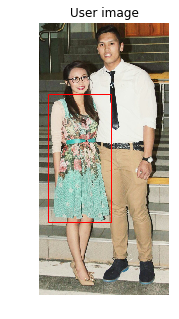

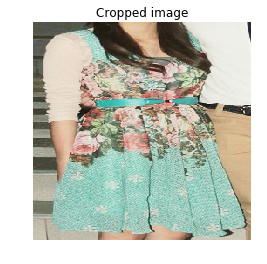

Top 10 similar images


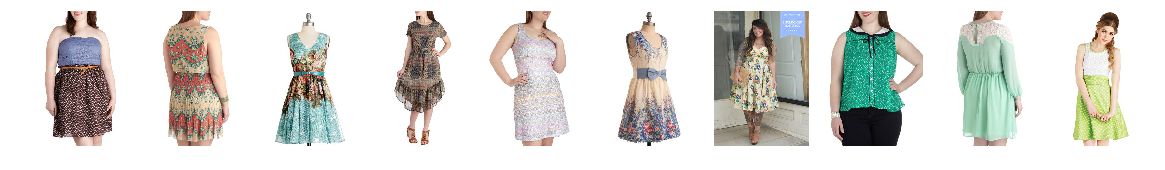

Same images ranked on indices: [2]
Wall time: 1.34 s


In [63]:
%%time
target_img = "./photos_store/customer/16071.jpg" #6324.jpg #CHECK PHOTO 13279.jpg TO FIX
rank = recommend_user(target_img, embs_catalogue, resize=resizing)

n = 10
rank_n = [0,n]
similar_ranked, retrieval_ranked = rank_similar(target_img, customer_final, retrieval_final, rank)
show_recommend(rank_n, os.path.join(dataset_path, "retrieval"), target_img, retrieval_ranked, resize=resizing)
print("Same images ranked on indices: {}".format(similar_ranked))

## Measuring model performance

Once we have created a embeddings catalogue from which the most "n" similiar images are returned we need to measure how this process is performing.<br>
This score will allow us to make improvements and meassure them, in order to find the best parameters and methods.

For the evaluation we will only use the customer photos, and each one of them will be compared with the retrieved photos. As a result we will obtain a rank starting from the most similar photo. Then we will define a K parámeter that will set the top k images from the returned rank.

For the evaluation we will use the following method:
   - Accuracy@K: total number of positive cases / total number of cases

In [27]:
def evaluate(customer_df, retrieval_df, dataset_path, embs_catalogue, k_list, resize=resizing, method="cosine"):
    
    #assumes customer_df already includes all images we will use
    customer_paths = [os.path.join(".", "photos_store", "customer", str(img) + ".jpg") for img in customer_df["photo"].tolist()]
    
    positives = {"dresses": np.empty((1, len(k_list)))[0],
                 "tops": np.empty((1, len(k_list)))[0],
                 }

    with tqdm(total=len(customer_paths)) as pbar:    
        for n, customer_path in enumerate(customer_paths):
            
            rank = recommend_user(customer_path, embs_catalogue, resize=resize, method=method)
            retrieval_ranked = retrieval_df.iloc[rank] #retrieval ranked
            retrieval_ranked = retrieval_ranked.drop_duplicates(subset=["id"], keep="first") #ensures only the best match for each item is taken into account

            for i, k in enumerate(k_list):
                retrieval_ranked_list = retrieval_ranked[:k]["id"].tolist()

                photo_name = re.split("(\\d+)", customer_path)[-2]
                image_customer = customer_df[customer_df["photo"] == int(photo_name)]
                image_id = image_customer['id'].tolist()[0] #always same id even if more than >1 rows
                image_category = image_customer["category"].tolist()[0]

                if image_id in retrieval_ranked_list:
                    positives[image_category][i] += 1
            pbar.update(1)
        
        for i, k in enumerate(k_list): #iterates over levels of k
            print("****************** Accuracy at {} ******************".format(k))
            for cat in positives.keys(): #iterates over categories
                total_cat = customer_df[customer_df["category"] == cat].shape[0]
                
                accuracy = positives[cat][i] / total_cat        
                print("{}: {:.3f}%".format(cat, accuracy*100))

In [28]:
%%time
k = [5,10,20,30,40,50]
evaluate(customer_final, retrieval_final, dataset_path, embs_catalogue, k, resize=resizing)

C:\Users\heret\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (99272481 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\heret\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (123871510 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


****************** Accuracy at 5 ******************
dresses: 21.998%
tops: 22.595%
****************** Accuracy at 10 ******************
dresses: 29.203%
tops: 28.866%
****************** Accuracy at 20 ******************
dresses: 37.658%
tops: 35.137%
****************** Accuracy at 50 ******************
dresses: 49.366%
tops: 46.649%

Wall time: 47min 32s


In order to improve the accuracy we tried different Pre-Trained Models from Keras. On the image below you can find the Accuracy@K for each model.  
We decided to use ResNet50 as it seems to be the one that performs better.

![IMAGE](https://i.imgur.com/0Fn7Ktj.jpg)

## Visualisation - TSNE

In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [23]:
#first applying PCA to reduce computation time
pca = PCA(n_components=150)
embeddings_pca = pca.fit_transform(embs_catalogue)
print(pca.explained_variance_ratio_.sum())

0.7801382269165466


In [26]:
%%time
tsne = TSNE(n_components=2, random_state=2018, n_iter=250) #15:48
X_2d = tsne.fit_transform(embeddings_pca)

Wall time: 12min 26s


In [ ]:
# dresses      13477
# footwear      7260
# tops          2475
# skirts        2417
# leggings      1736
# outerwear     1254
# bags           597
# pants          478
# hats           359
# eyewear        290
# belts          185

Total images:  31927


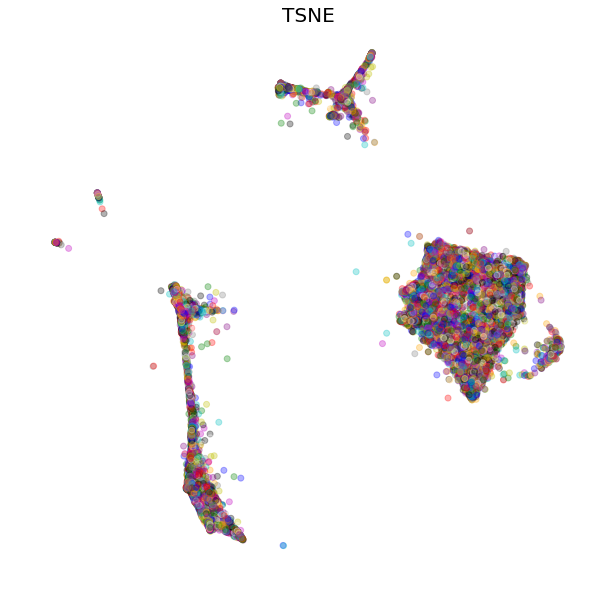

In [35]:
print("Total images: ", X_2d.shape[0])
# https://www.kaggle.com/mrisdal/dimensionality-reduction-with-umap-on-mnist CHECK OUT UMAP
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("TSNE",fontsize=20)

colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple', "grey"
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.3, c=colors)
plt.axis("off")
plt.show()

Total images:  2778


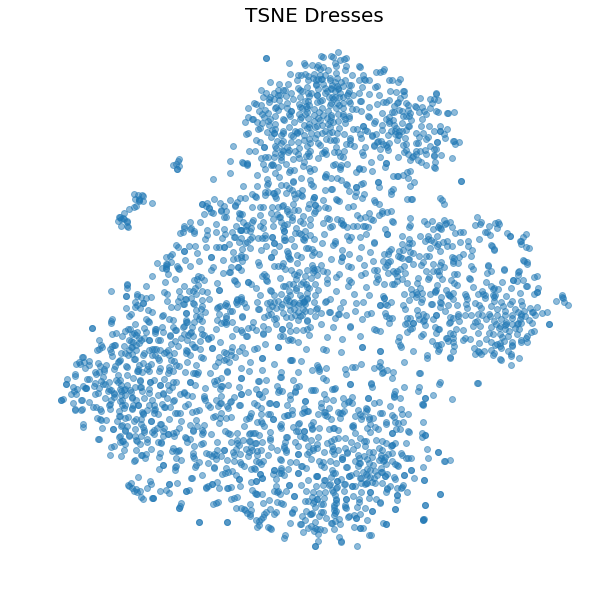

In [26]:
print("Total images: ", X_2d.shape[0])

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("TSNE Dresses",fontsize=20)

plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.5)
plt.axis("off")
plt.show()

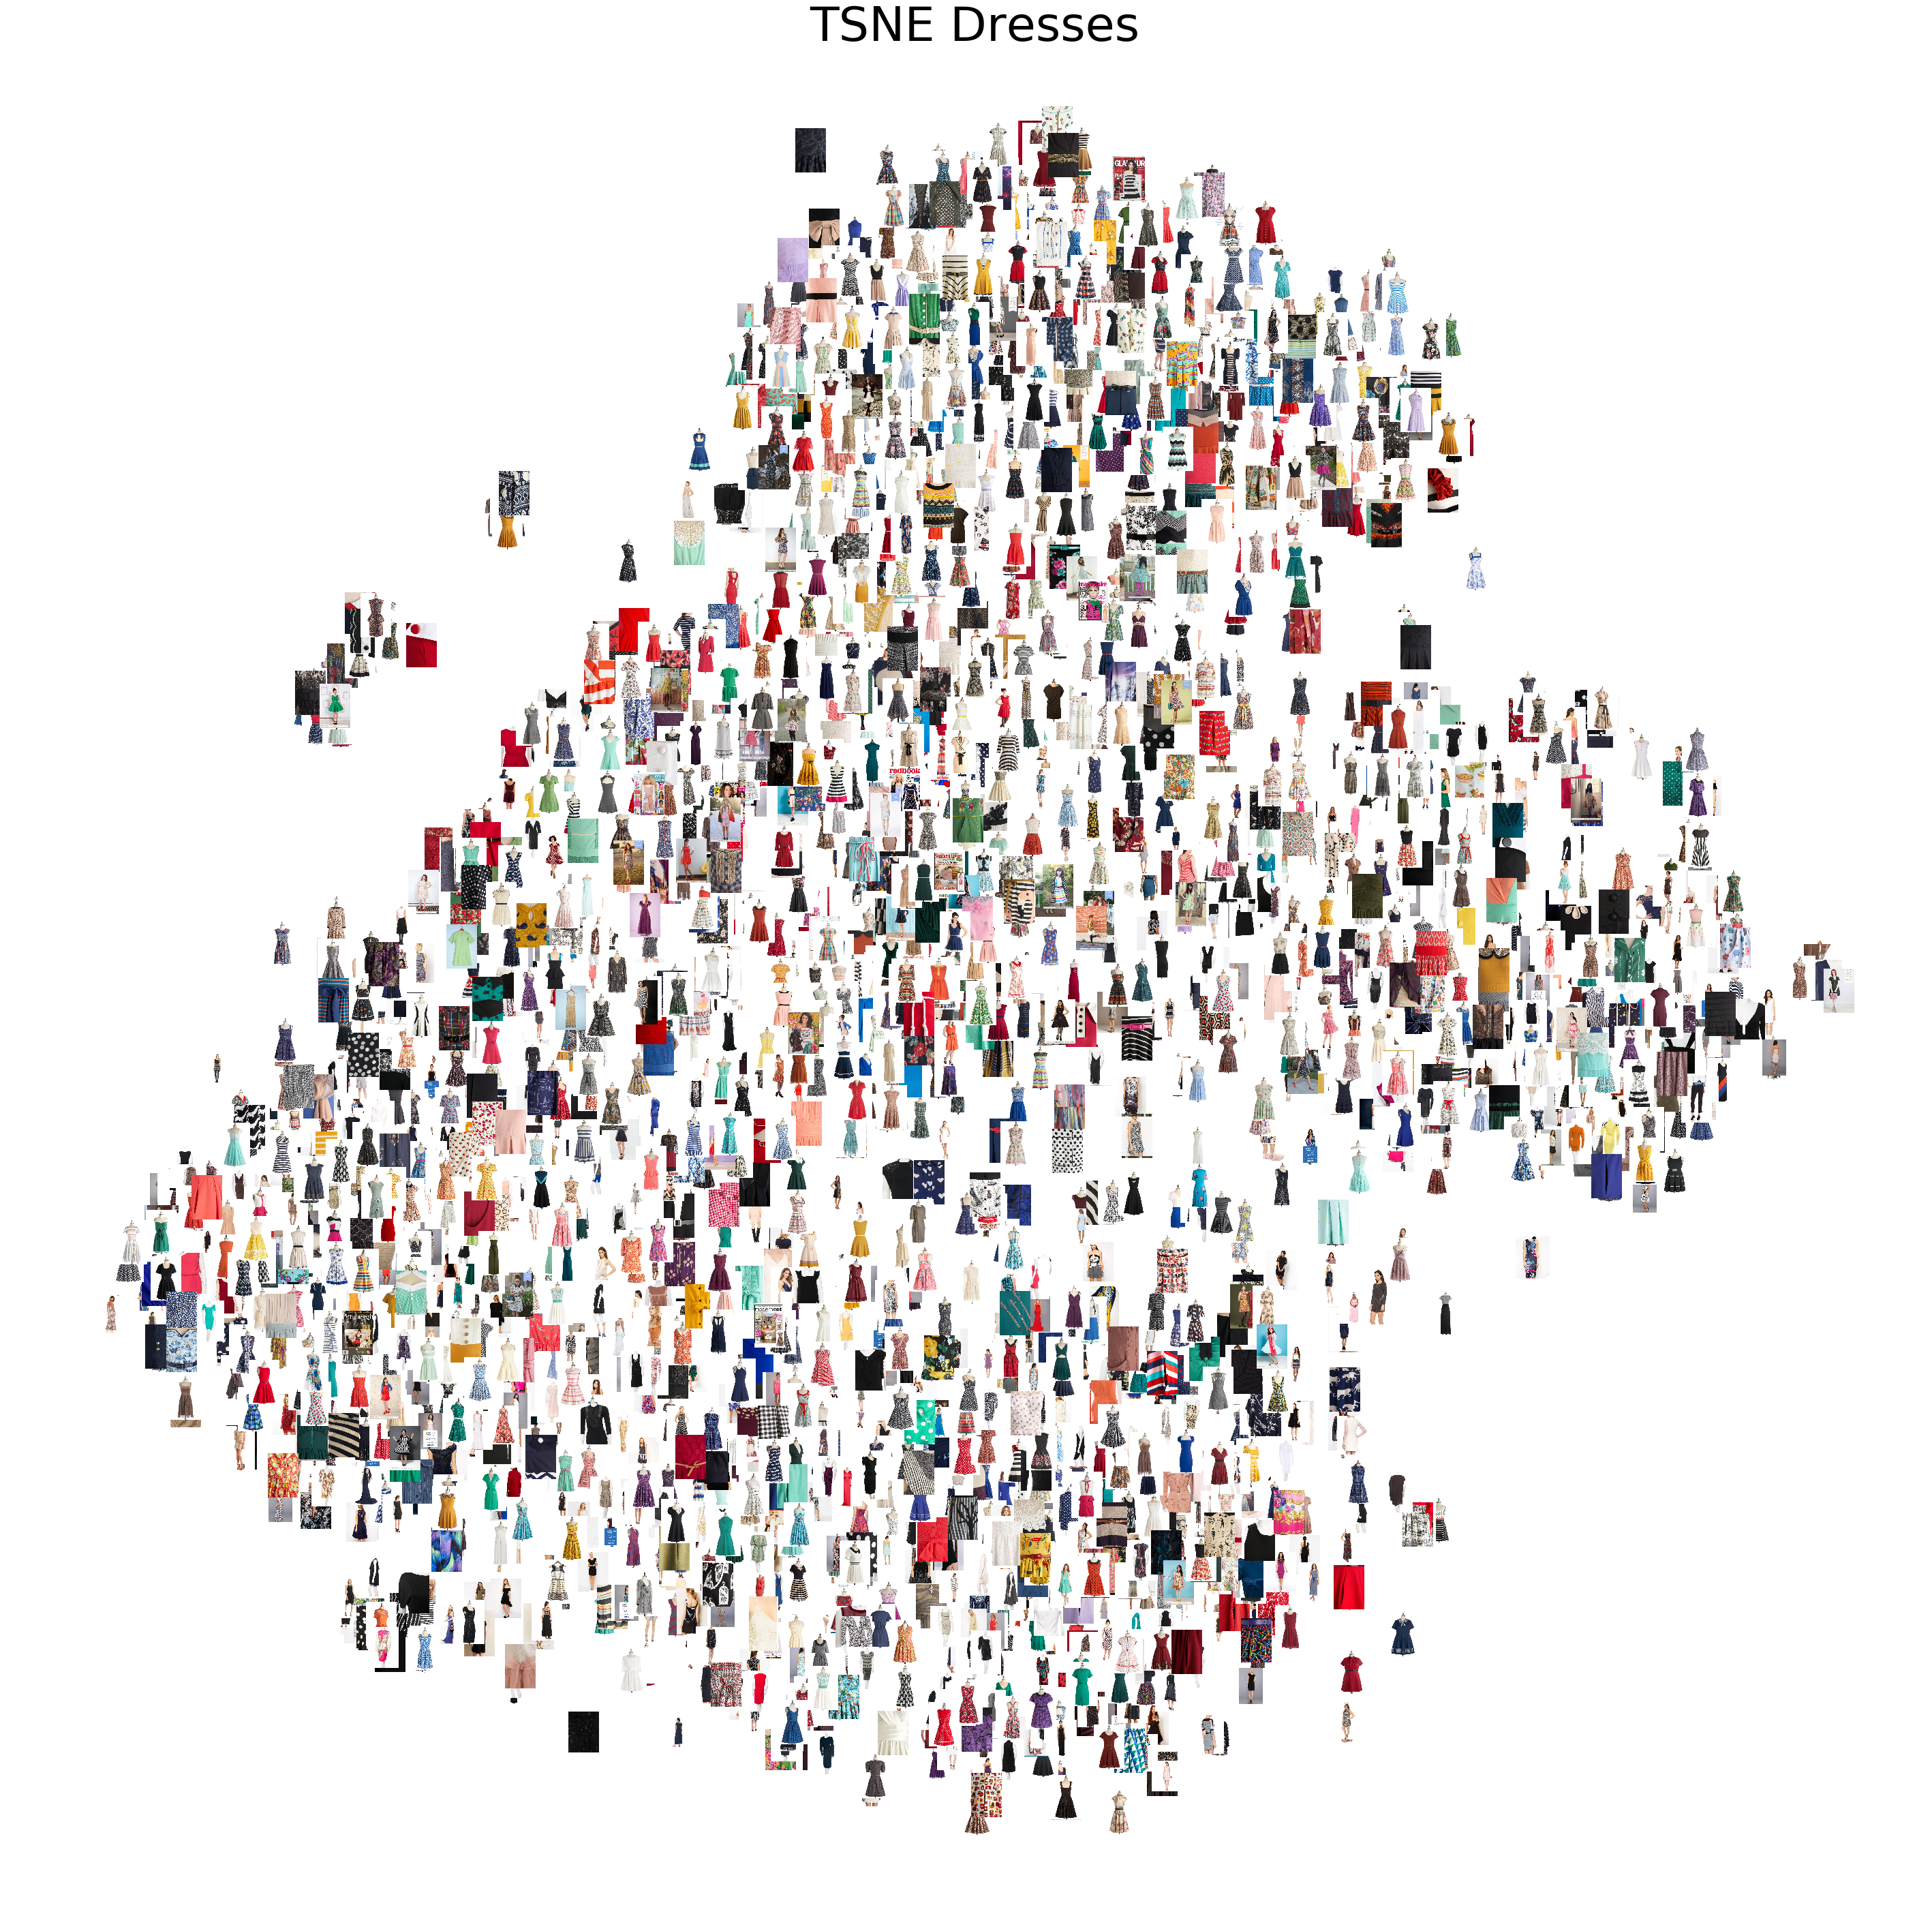

In [28]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scatter_images(x, y, image_array, ax, zoom=0.1):
    im = OffsetImage(image_array, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    abox = AnnotationBbox(im, (x, y), xycoords="data", frameon=False)
    artists = ax.add_artist(abox)
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

img_list = os.listdir(dataset_path + "retrieval")
img_list = [os.path.join(dataset_path, "retrieval", img) for img in img_list]

fig, ax = plt.subplots(figsize=(50,50))
ax.set_title("TSNE Dresses",fontsize=70)

with tqdm(total=len(img_list)) as pbar:
    for img, xy in zip(img_list, X_2d):
        img_array = plt.imread(img)
        x_ax =  xy[0]
        y_ax = xy[1]

        scatter_images(x_ax, y_ax, img_array, ax, zoom=0.15)
        pbar.update(1)
    plt.axis("off")
    #plt.savefig("tsne-dresses.png")
    plt.show()